In [1]:
import sys
import platform
from os.path import join, exists, abspath
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
import h5py
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [4]:
path_module = abspath(join(dir_git,'nitools'))
if exists(path_module):
    print('added the path, %s'%path_module)
    if path_module not in sys.path:
        sys.path.append(path_module)

import nitools as nt

added the path, /home/sungbeenpark/github/nitools


In [5]:
path_module = abspath(join(dir_git,'SUITPy'))
if exists(path_module):
    print('added the path, %s'%path_module)
    if path_module not in sys.path:
        sys.path.append(path_module)

import SUITPy as suit

added the path, /home/sungbeenpark/github/SUITPy


In [6]:
path_module = abspath(dir_git)
if exists(path_module):
    print('added the path, %s'%path_module)
    if path_module not in sys.path:
        sys.path.append(path_module)

import surfAnalysisPy as surf

added the path, /home/sungbeenpark/github


In [7]:
OS_name = platform.system()
if OS_name == 'windows':
    ## window
    dir_work = join('F:/SeqSpatialSupp_fMRI')
elif OS_name == 'Linux':
    ## Linux
    dir_work = join('/mnt/f/SeqSpatialSupp_fMRI')
elif OS_name == 'Darwin':
    ## MacOS
    dir_work = join('/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI')
print(exists(dir_work))
dir_result = join(dir_work, 'results')
makedirs(dir_result, exist_ok=True)

True


In [8]:
tmp = [1,2,3,5,6,8,9,10,11,12,13,14]
list_nn = ['%02d'%i for i in tmp]
list_nn

['01', '02', '03', '05', '06', '08', '09', '10', '11', '12', '13', '14']

---

In [9]:
nn = '01'

In [10]:
run = 1

---

### Anatomical S

In [11]:
dir_anat = join(dir_work, 'anatomicals')
exists(dir_anat)

True

In [12]:
def load_anat(subj, dir_anat):
    if len(subj)==2:
        subj = 'S'+subj
    else:
        subj = subj.replace('R','S')
    fname = join(dir_anat, subj, '%s_anatomical.nii'%subj)
    img = nb.load(fname)

    return img

In [13]:
img_anat = load_anat(nn, dir_anat)

(224, 353, 353)

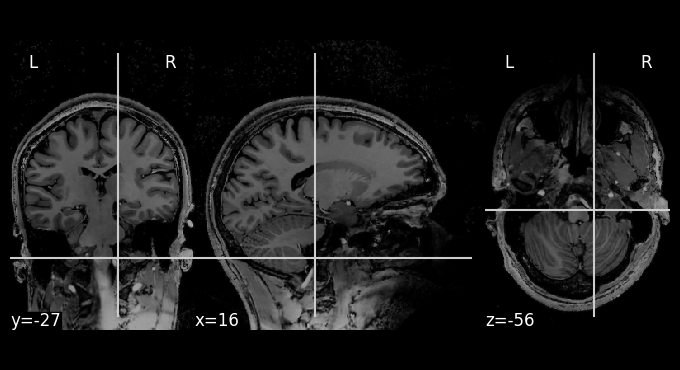

In [14]:
plotting.plot_anat(img_anat)
img_anat.shape

---

### functional S vs R

In [15]:
def load_func(subj, dir_func, run=1, reslice=False):
    ss = subj[0]
    if ss == 'S':
        fname = join(dir_func, subj, '%s_run_%02d.nii'%(subj,run))
    elif ss == 'R':
        if reslice:
            fname = join(dir_func, subj, 'resliced_%s_run_%02d.nii'%(subj,run))
        else:
            fname = join(dir_func, subj, '%s_run_%02d.nii'%(subj,run))
    img = nb.load(fname)

    return img

In [16]:
dir_func = join(dir_work, 'imaging_data')
exists(dir_func)

True

In [17]:
img_func_S = load_func(subj='S'+nn, dir_func=dir_func, run=run)
img_func_R = load_func(subj='R'+nn, dir_func=dir_func, run=run, reslice=True)

/home/sungbeenpark/anaconda3/envs/sss/lib/python3.8/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


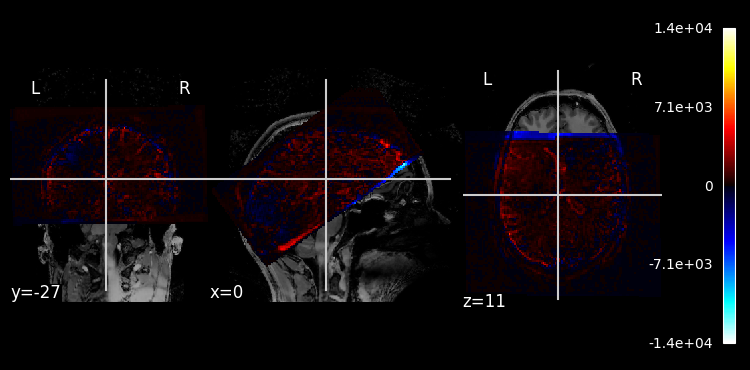

In [18]:
TR = 0
slice_S = image.index_img(img_func_S, index=TR)
slice_R = image.index_img(img_func_R, index=TR)
plotting.plot_stat_map(
    stat_map_img = image.math_img('img1 - img2', img1=slice_S, img2=slice_R),
    bg_img = img_anat
)

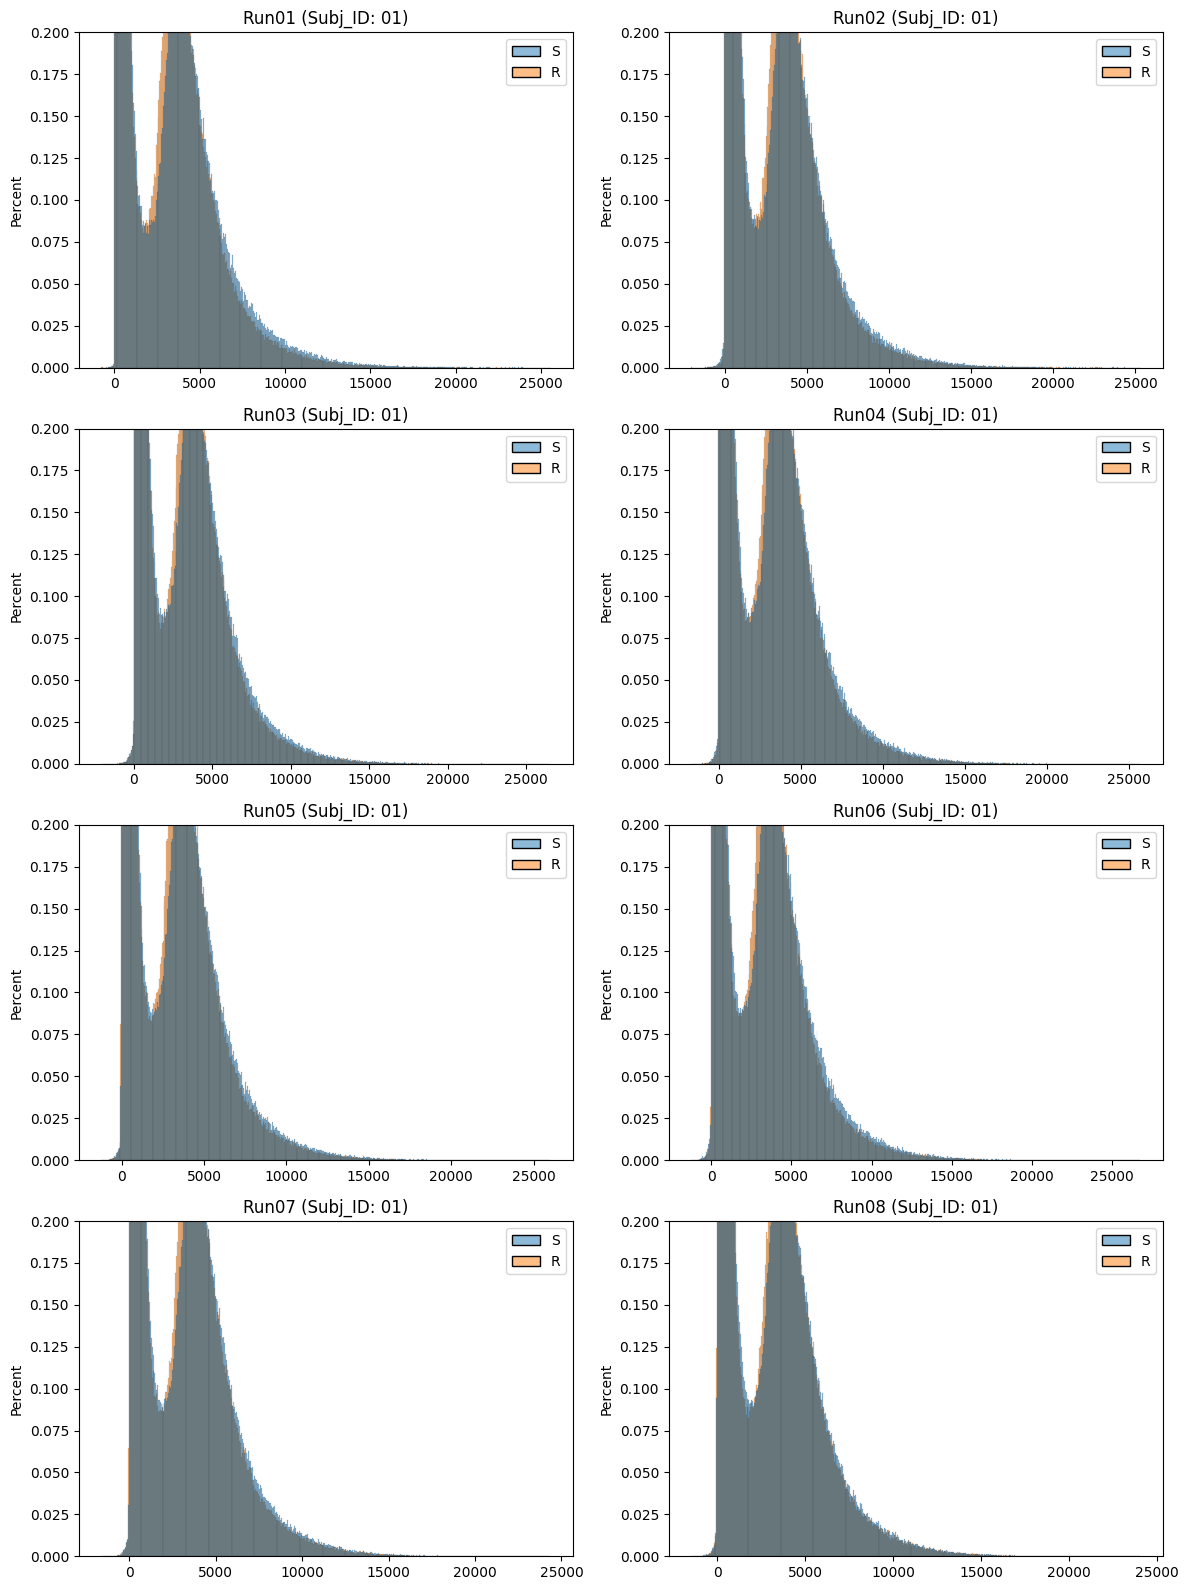

In [19]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12,16))
axs = np.concatenate(axs)

TR = 0
for rr in range(8):
    ax = axs[rr]
    run = rr+1
    
    img_func_S = load_func(subj='S'+nn, dir_func=dir_func, run=run)
    img_func_R = load_func(subj='R'+nn, dir_func=dir_func, run=run)
    
    slice_S = image.index_img(img_func_S, index=TR)
    slice_R = image.index_img(img_func_R, index=TR)

    df = pd.DataFrame()
    df['S'] = slice_S.get_fdata().reshape(-1)
    df['R'] = slice_R.get_fdata().reshape(-1)
    df.replace(0., np.nan, inplace=True)
    
    sns.histplot(df, stat='percent', ax=ax)
    ax.set_ylim(0,.2)
    ax.set_title('Run%02d (Subj_ID: %s)'%(run,nn))

fig.tight_layout()

In [20]:
del img_func_S, slice_S
del img_func_R, slice_R

### functional R_orig vs R_resliced

FileNotFoundError: No such file or no access: '/mnt/f/SeqSpatialSupp_fMRI/imaging_data/R01/resliced_R01_run_03.nii'

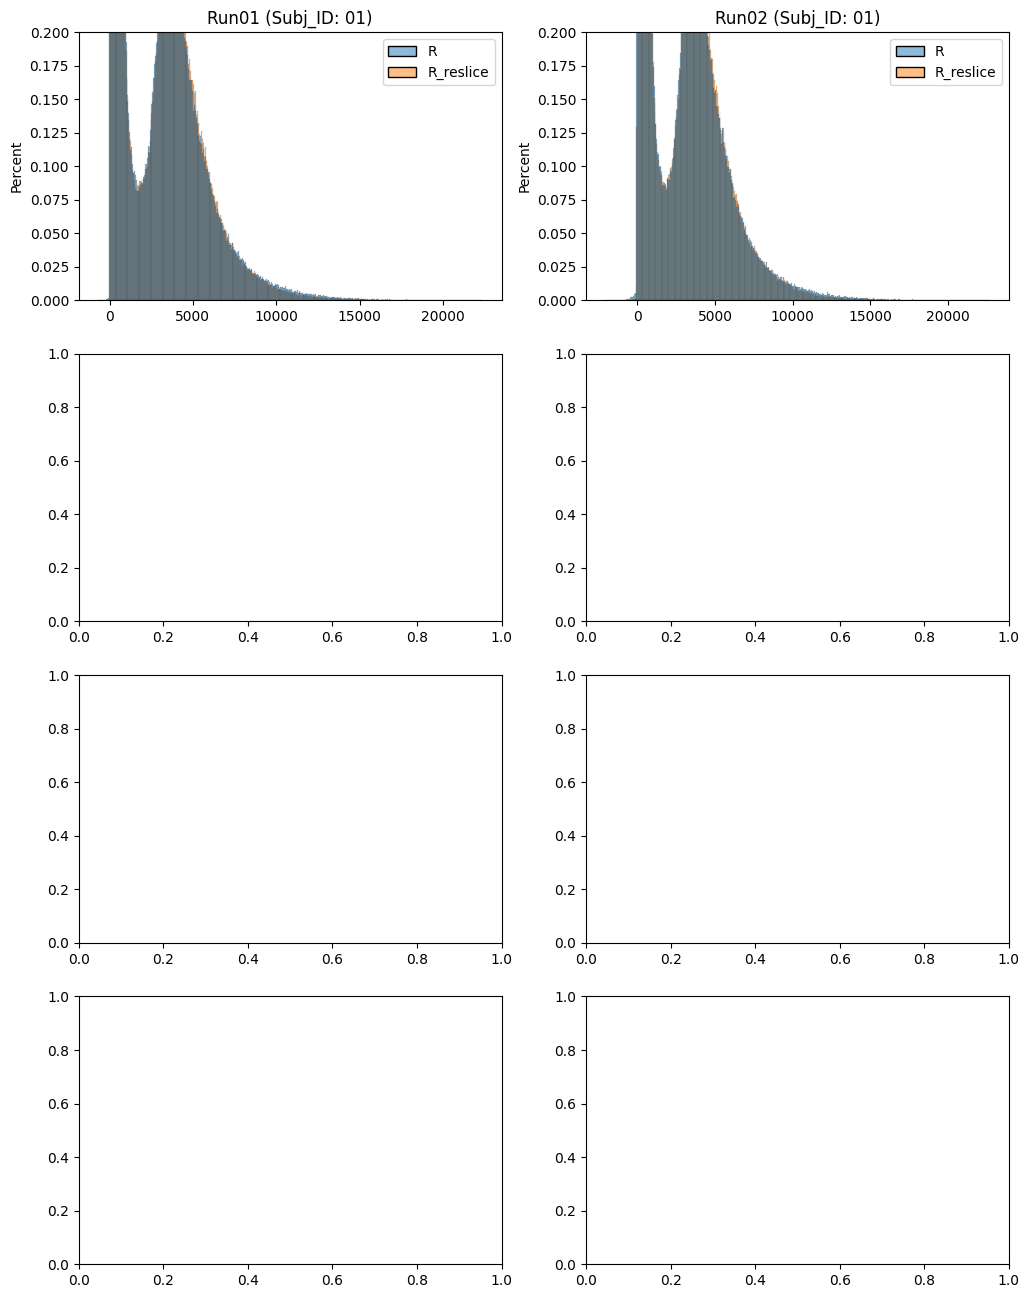

In [21]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12,16))
axs = np.concatenate(axs)

TR = 0
for rr in range(8):
    ax = axs[rr]
    run = rr+1
    
    img_func_R = load_func(subj='R'+nn, dir_func=dir_func, run=run, reslice=False)
    img_func_R_reslice = load_func(subj='R'+nn, dir_func=dir_func, run=run, reslice=True)
    
    R = image.index_img(img_func_R, index=TR)
    R_reslice = image.index_img(img_func_R_reslice, index=TR)

    df = pd.DataFrame()
    df['R'] = R.get_fdata().reshape(-1)
    df['R_reslice'] = R_reslice.get_fdata().reshape(-1)
    df.replace(0., np.nan, inplace=True)
    
    sns.histplot(df, stat='percent', ax=ax)
    ax.set_ylim(0,.2)
    ax.set_title('Run%02d (Subj_ID: %s)'%(run,nn))

fig.tight_layout()

In [ ]:
del img_func_R, R
del img_func_R_reslice, R_reslice

---